In [ ]:
!pip install qiskit==1.2.4
!pip install matplotlib
!pip install qiskit-aer==0.15.1
!pip install pylatexenc

In [ ]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_bloch_multivector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import pylatexenc
from qiskit_aer import AerSimulator, Aer
from qiskit.quantum_info import Statevector, Operator
import numpy as np

In [ ]:
# parameters
q = 4
n = 4  # 4 qubits

A = np.array([[1, 2],
              [3, 1]])
s_real = np.array([1, 3])
e = np.array([0, 1])
t = (A @ s_real + e) % q

print(f"Public value of t: {t}")



Public value of t: [3 3]


In [ ]:

# Tolerance
delta = 1

def bits_to_s(bitstring):
    s0 = int(bitstring[:2], 2)
    s1 = int(bitstring[2:], 2)
    return np.array([s0, s1])


def is_acceptable_s(bitstring):
    s_vec = bits_to_s(bitstring)
    diff = (A @ s_vec - t) % q
    return np.all(diff <= delta) or np.all(diff >= q - delta)

# Find all the acceptable s
acceptable_s = []
for i in range(16):
    bits = format(i, "04b")
    if is_acceptable_s(bits):
        acceptable_s.append(bits)

print(f"Acceptable solutions with delta={delta}:", acceptable_s)

def oracle(n, acceptable_s):
    qc = QuantumCircuit(n)
    for sol in acceptable_s:
        for i, bit in enumerate(sol):
            if bit == '0':
                qc.x(i)
        qc.h(n-1)
        qc.mcx(list(range(n-1)), n-1)
        qc.h(n-1)
        for i, bit in enumerate(sol):
            if bit == '0':
                qc.x(i)
    return qc

def grover_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

# Grover building
grover = QuantumCircuit(n, n)
grover.h(range(n)) #Superposition
grover.append(oracle(n, acceptable_s), range(n)) #Grover oracle
grover.append(grover_diffuser(n), range(n)) #inversion about the mean
grover.measure(range(n), range(n))

# Simulation
backend = Aer.get_backend('qasm_simulator')
compiled = transpile(grover, backend)
result = backend.run(compiled, shots=1024).result()
counts = result.get_counts()




Acceptable solutions with delta=1: ['0000', '0101', '1000', '1001', '1110']


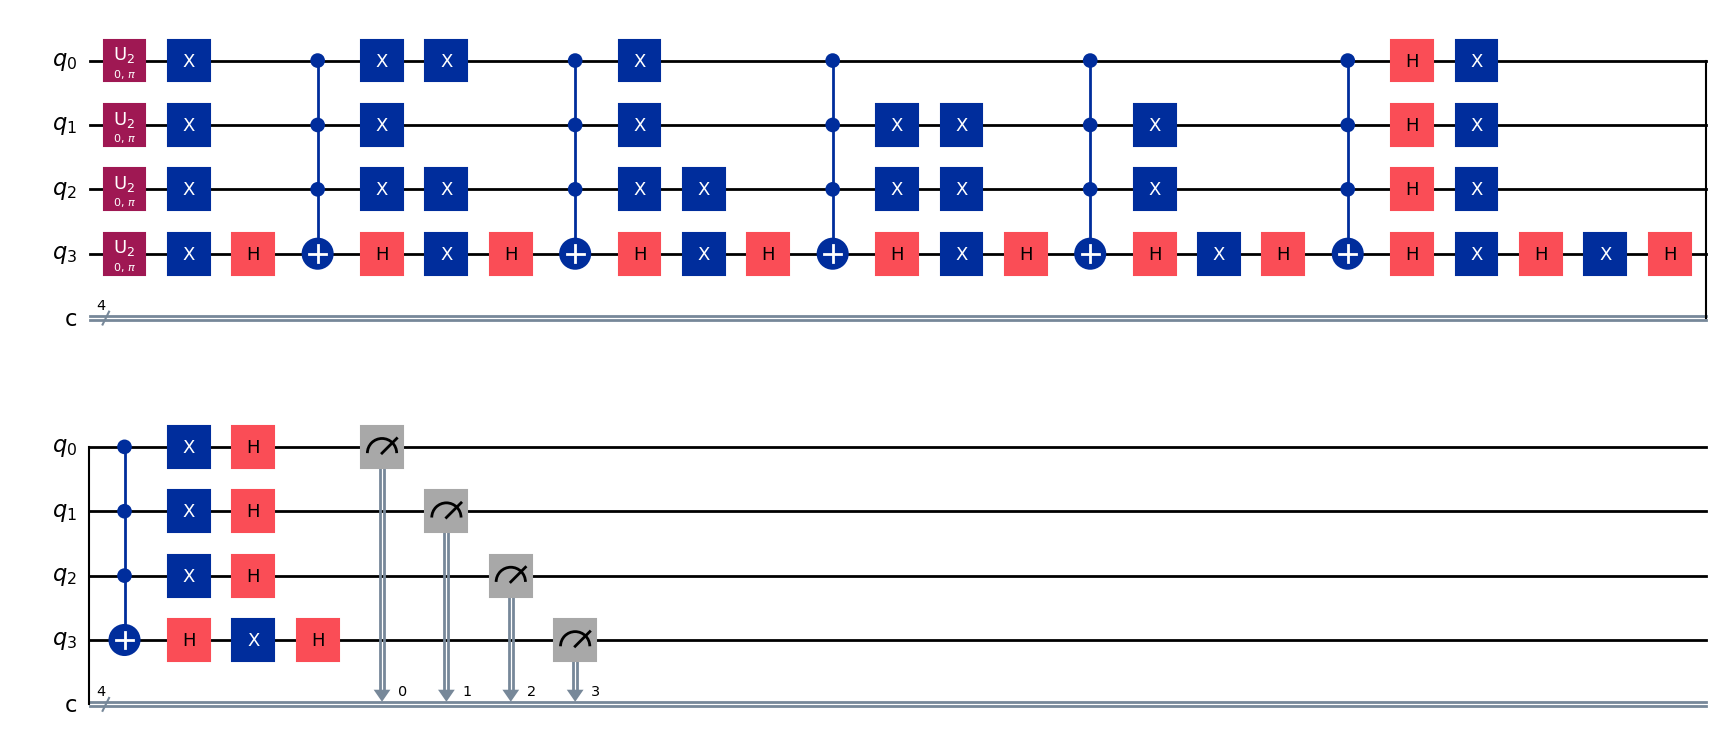

In [ ]:
grover.decompose().draw(output='mpl', style={'dpi': 50})


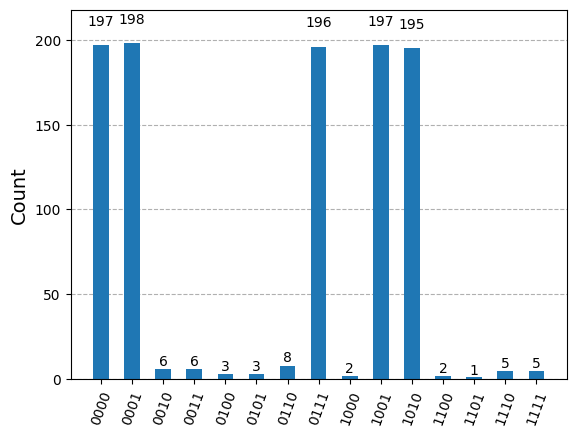

In [ ]:
# Mostra risultati
plot_histogram(counts)



In [ ]:
# Stampa la soluzione più probabile trovata
best = max(counts, key=counts.get)
print(f"Most probable solution (bitstring): {best}")
print(f"Related s vector: {[int(best[:2],2), int(best[2:],2)]}")

Soluzione più probabile trovata (bitstring): 0001
Vettore s corrispondente: [0, 1]
